In [1]:
!pip install transformers
!pip install torch
!pip install tqdm
!pip install kaggle
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.5/397.5 kB 6.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle_API/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d abdelrahmanmosly/twitter15-16-weibo

  0% 0.00/4.34M [00:00<?, ?B/s]
100% 4.34M/4.34M [00:00<00:00, 89.2MB/s]


In [5]:
!unzip twitter15-16-weibo.zip

Archive:  twitter15-16-weibo.zip
  inflating: twitter15/twitter15.dev  
  inflating: twitter15/twitter15.test  
  inflating: twitter15/twitter15.train  
  inflating: twitter15/twitter15_graph.txt  
  inflating: twitter16/twitter16.dev  
  inflating: twitter16/twitter16.test  
  inflating: twitter16/twitter16.train  
  inflating: twitter16/twitter16_graph.txt  
  inflating: weibo/weibo.dev         
  inflating: weibo/weibo.test        
  inflating: weibo/weibo.train       
  inflating: weibo/weibo.txt         
  inflating: weibo/weibo_graph.txt   


In [6]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


In [7]:
import pandas as pd

# Path to the text file
txt_file_path = '/content/twitter15/twitter15.train'

# Define column names
column_names = ['ID', 'Text', 'Label']

# Read the text file into a DataFrame
train_df_from_txt = pd.read_csv(txt_file_path, sep='\t', header=None, names=column_names)

# Print the head of the DataFrame
print(train_df_from_txt.head())

                   ID                                               Text  \
0  724703995147751424  american family association gets 500,000 to si...   
1  358591089462099968  this week's top story: george zimmerman wins f...   
2  775672628493357057  clinton hides failing health? full disclosure ...   
3  364589696573124609  fukushima: highly radioactive water seeping in...   
4  549927969032916993  a transgender 17-year old left a suicide note ...   

        Label  
0  unverified  
1       false  
2  unverified  
3       false  
4  unverified  


In [8]:
# Path to the text file
txt_file_path = '/content/twitter15/twitter15.dev'

# Define column names
column_names = ['ID', 'Text', 'Label']

# Read the text file into a DataFrame
val_df_from_txt = pd.read_csv(txt_file_path, sep='\t', header=None, names=column_names)

print(val_df_from_txt.head())

                   ID                                               Text  \
0  693136527816331264  a tiny alpine town in northern italy just welc...   
1  755475529294352385  ohio police officer hospitalized after eating ...   
2  744390771869102080  one of the men who wanted to copy the #orlando...   
3  534445263528947712  missouri governor declares state of emergency ...   
4  691027026552229888  donald trump spokesperson decried lack of "pur...   

        Label  
0   non-rumor  
1  unverified  
2  unverified  
3       false  
4   non-rumor  


In [9]:
# Path to the text file
txt_file_path = '/content/twitter15/twitter15.test'

# Define column names
column_names = ['ID', 'Text', 'Label']

# Read the text file into a DataFrame
test_df_from_txt = pd.read_csv(txt_file_path, sep='\t', header=None, names=column_names)

print(test_df_from_txt.head())

                   ID                                               Text  \
0  507257950868885504  breaking: ap source: tesla motors has selected...   
1  407213772328022016  fast and furious star paul walker dead in car ...   
2  531525016794697729  more: officials say they do not know the exten...   
3  689214940679409664     #eagles co-founder glenn frey has died aged 67   
4  656361703664451585  well done scotland! 5p carrier bag charge 1 yr...   

        Label  
0        true  
1        true  
2  unverified  
3   non-rumor  
4  unverified  


In [10]:
train_text = train_df_from_txt.iloc[:, 1].tolist()
train_labels = train_df_from_txt.iloc[:, 2].tolist()
val_text = val_df_from_txt.iloc[:, 1].tolist()
val_labels = val_df_from_txt.iloc[:, 2].tolist()
test_text = test_df_from_txt.iloc[:, 1].tolist()
test_labels = test_df_from_txt.iloc[:, 2].tolist()

In [11]:
# Assuming train_labels and test_labels are lists of strings containing 'true', 'non rumors', 'false', or 'unverified'

# Define a mapping for label conversion
label_mapping = {'true': 0, 'non-rumor': 1, 'false': 2, 'unverified': 3}

# Convert train_labels
train_labels = [label_mapping[label] for label in train_labels]

val_labels = [label_mapping[label] for label in val_labels]

# Convert test_labels
test_labels = [label_mapping[label] for label in test_labels]


In [12]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW

def fine_tune_bertweet_for_rumor_detection(train_texts, train_labels, val_texts, val_labels, epochs=10, batch_size=8, learning_rate=2e-5, patience=3):
    # Initialize BERTweet tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-base')
    model = AutoModelForSequenceClassification.from_pretrained('vinai/bertweet-base', num_labels=4)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    # Tokenize and encode the training and validation sets
    train_encodings = tokenizer(train_texts, truncation=True, padding=True, return_tensors='pt')
    val_encodings = tokenizer(val_texts, truncation=True, padding=True, return_tensors='pt')

    # Move tensors to GPU
    train_encodings = {key: value.to(device) for key, value in train_encodings.items()}
    val_encodings = {key: value.to(device) for key, value in val_encodings.items()}

    # Convert labels to PyTorch tensors
    train_labels = torch.tensor(train_labels).to(device)
    val_labels = torch.tensor(val_labels).to(device)

    # Create PyTorch datasets
    train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
    val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)

    # Create PyTorch data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Set up optimizer
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # Initialize early stopping variables
    best_val_loss = float('inf')
    no_improvement_counter = 0

    # Training loop
    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            input_ids, attention_mask, labels = batch
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = batch
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                val_loss += outputs.loss.item()
                logits = outputs.logits
                predictions = torch.argmax(logits, dim=1)
                correct_predictions += (predictions == labels).sum().item()
                total_samples += labels.size(0)

        average_val_loss = val_loss / len(val_loader)
        accuracy = correct_predictions / total_samples

        print(f'Epoch {epoch + 1}/{epochs}, Val Loss: {average_val_loss}, Accuracy: {accuracy}')

        # Check for early stopping
        if average_val_loss < best_val_loss:
            best_val_loss = average_val_loss
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1

        if no_improvement_counter >= patience:
            print(f'Early stopping at epoch {epoch + 1} as validation loss did not improve for {patience} consecutive epochs.')
            break

    return model


In [14]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split

model = fine_tune_bertweet_for_rumor_detection(train_text, train_labels, val_text, val_labels)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10, Val Loss: 1.2175070925762779, Accuracy: 0.4429530201342282
Epoch 2/10, Val Loss: 0.8570012261993006, Accuracy: 0.6845637583892618
Epoch 3/10, Val Loss: 0.6878021210432053, Accuracy: 0.7583892617449665
Epoch 4/10, Val Loss: 0.7961921429163531, Accuracy: 0.7516778523489933
Epoch 5/10, Val Loss: 0.7877294301594558, Accuracy: 0.7651006711409396
Epoch 6/10, Val Loss: 0.8709362142376209, Accuracy: 0.7651006711409396
Early stopping at epoch 6 as validation loss did not improve for 3 consecutive epochs.


In [15]:
import torch
from transformers import AutoTokenizer

def make_predictions(model, texts):
    # Tokenize the input texts
    tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-base')
    inputs = tokenizer(texts, truncation=True, padding=True, return_tensors='pt')

    # Move inputs to the same device as the model
    device = model.device
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Make predictions
    with torch.no_grad():
        outputs = model(**inputs)

    # Get predicted labels
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1).tolist()

    return predictions


Accuracy: 0.8125
Precision: 0.813819559971465
Recall: 0.8125
F1 Score: 0.8114856190452852
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        84
           1       0.82      0.75      0.78        84
           2       0.80      0.79      0.79        84
           3       0.85      0.80      0.82        84

    accuracy                           0.81       336
   macro avg       0.81      0.81      0.81       336
weighted avg       0.81      0.81      0.81       336

Confusion Matrix:
[[77  2  3  2]
 [ 6 63  9  6]
 [ 8  6 66  4]
 [ 6  6  5 67]]


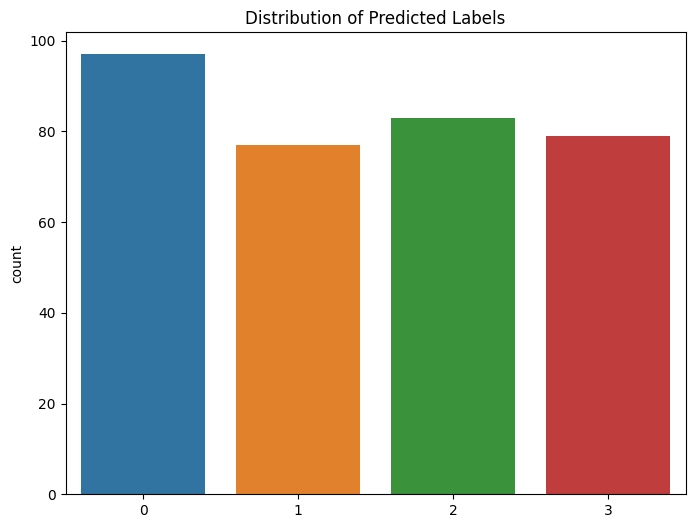

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        84
           1       0.82      0.75      0.78        84
           2       0.80      0.79      0.79        84
           3       0.85      0.80      0.82        84

    accuracy                           0.81       336
   macro avg       0.81      0.81      0.81       336
weighted avg       0.81      0.81      0.81       336



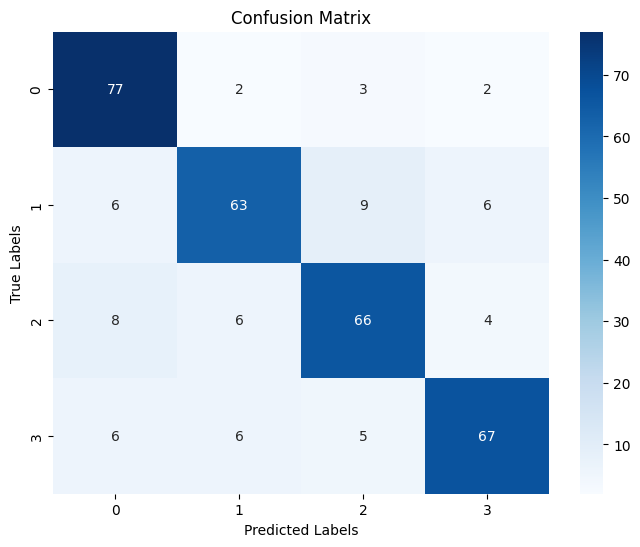

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Assuming model is already fine-tuned
# You can use the validation data for testing
test_predictions = make_predictions(model, test_text)

# Evaluate the model

accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions, average='weighted')
recall = recall_score(test_labels, test_predictions, average='weighted')
f1 = f1_score(test_labels, test_predictions, average='weighted')

# Display metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Display classification report and confusion matrix
print('Classification Report:')
print(classification_report(test_labels, test_predictions))

print('Confusion Matrix:')
conf_matrix = confusion_matrix(test_labels, test_predictions)
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.countplot(x=test_predictions)
plt.title('Distribution of Predicted Labels')
plt.show()


# Display classification report (replace 'true_labels' and 'predicted_labels' with your actual true and predicted labels)
print('Classification Report:')
print(classification_report(test_labels, test_predictions))


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(set(test_predictions)), yticklabels=list(set(test_labels)))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [17]:
def generate_wordcloud(text, title):
    if len(text) > 0:
        wordcloud = WordCloud(width=800, height=400, random_state=42, max_font_size=110).generate(text)
        plt.figure(figsize=(10, 7))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis('off')
        plt.title(title)
        plt.show()
    else:
        print(f"No text available for word cloud: {title}")

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      1005 non-null   int64 
 1   Text    1005 non-null   object
 2   Label   1005 non-null   object
dtypes: int64(1), object(2)
memory usage: 23.7+ KB
None

Summary Statistics:
                 ID
count  1.005000e+03
mean   5.737899e+17
std    1.135877e+17
min    8.008068e+16
25%    5.144294e+17
50%    5.365479e+17
75%    6.922874e+17
max    7.808825e+17

First Few Rows:
                   ID                                               Text  \
0  724703995147751424  american family association gets 500,000 to si...   
1  358591089462099968  this week's top story: george zimmerman wins f...   
2  775672628493357057  clinton hides failing health? full disclosure ...   
3  364589696573124609  fukushima: highly radioactive water seeping in...   
4  549927969032916993  a transgender 

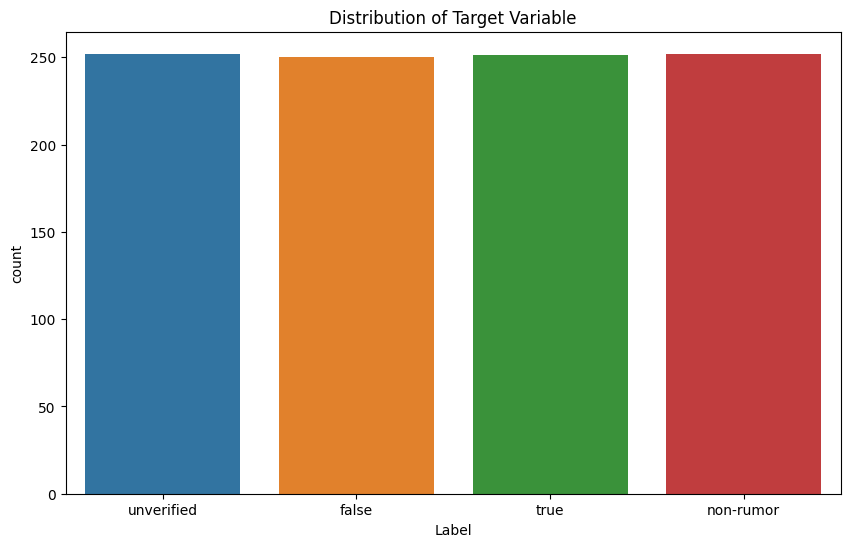

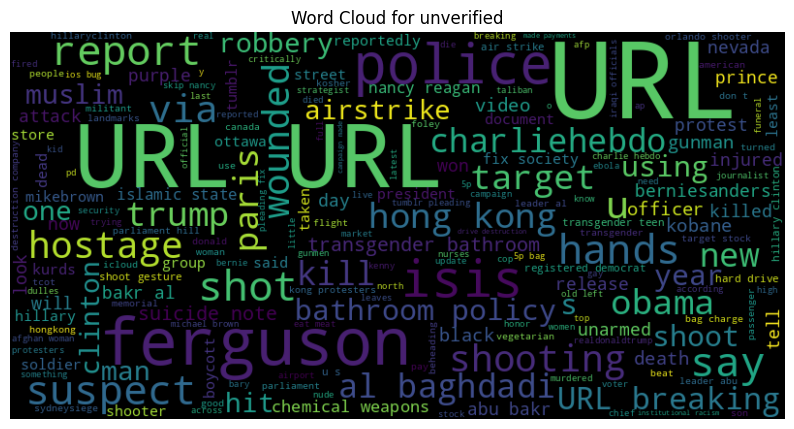

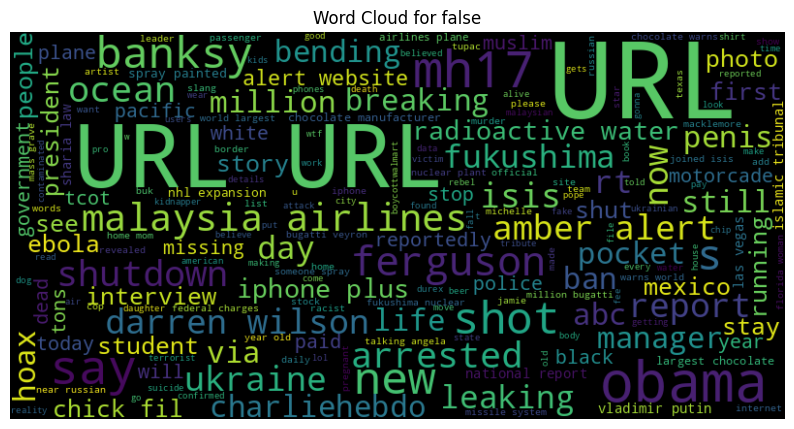

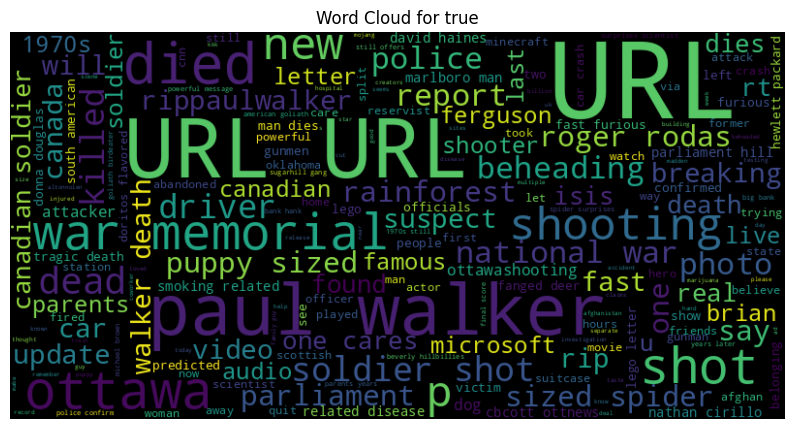

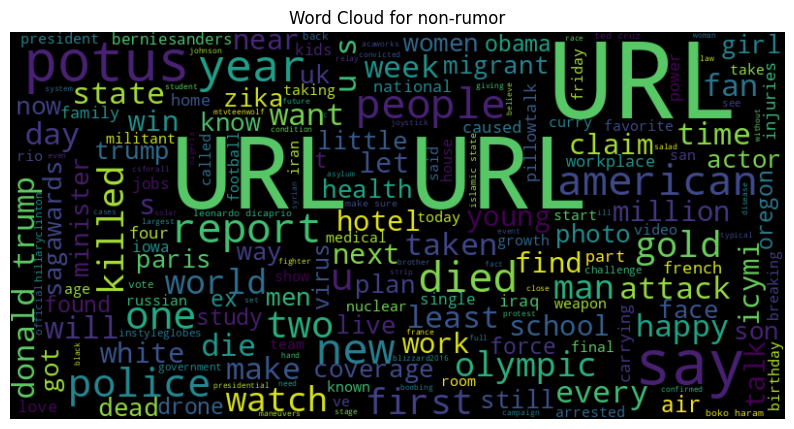

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from wordcloud import WordCloud  # Make sure to install the 'wordcloud' library

# Assuming train_df_from_txt is your DataFrame
# Load the data from a text file if needed
# train_df_from_txt = pd.read_csv('your_file.txt', sep='\t')

# Display basic information about the DataFrame
print("DataFrame Information:")
print(train_df_from_txt.info())

# Display summary statistics for numeric columns
print("\nSummary Statistics:")
print(train_df_from_txt.describe())

# Display the first few rows of the DataFrame
print("\nFirst Few Rows:")
print(train_df_from_txt.head())

# Visualize data distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Label', data=train_df_from_txt)
plt.title('Distribution of Target Variable')
plt.show()

# Generate word cloud for each class
for label_class in train_df_from_txt['Label'].unique():
    class_text = ' '.join(train_df_from_txt[train_df_from_txt['Label'] == label_class]['Text'])
    generate_wordcloud(class_text, f'Word Cloud for {label_class}')


